Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5821
           1       1.00      1.00      1.00     75072

    accuracy                           1.00     80893
   macro avg       1.00      1.00      1.00     80893
weighted avg       1.00      1.00      1.00     80893

Confusion Matrix:
[[ 5819     2]
 [    1 75071]]
Number of False Negatives: 1
Number of False Positives: 2
Accuracy Score: 0.9999629139727788
Number of Features Selected: 18


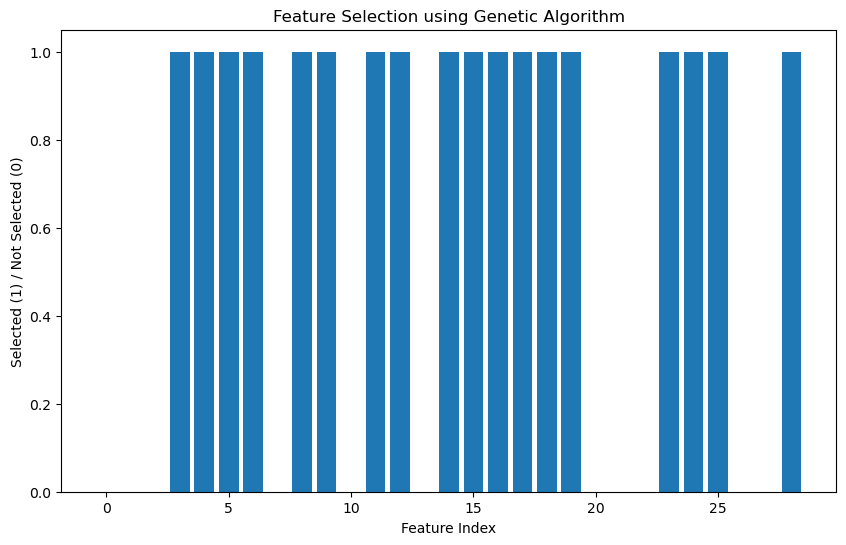

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the datasets
benign = pd.read_csv('l2-benign.csv')
malicious = pd.read_csv('l2-malicious.csv')

# Combine the datasets
data = pd.concat([benign, malicious], ignore_index=True)

# Drop columns we want to ignore
data.drop(['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'TimeStamp'], axis=1, inplace=True)

# Encode labels
data['Label'] = data['Label'].map({'Benign': 0, 'Malicious': 1})

# Split data into features and target
X = data.drop('Label', axis=1)
y = data['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the genetic algorithm for feature selection
def genetic_algorithm_feature_selection(X_train, y_train, n_gen=10, pop_size=20):
    n_features = X_train.shape[1]
    
    # Define individual and fitness functions
    creator.create('FitnessMax', base.Fitness, weights=(1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)
    
    toolbox = base.Toolbox()
    toolbox.register('attr_bool', np.random.randint, 0, 2)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    
    def eval_one_max(individual):
        mask = np.array(individual, dtype=bool)
        if np.sum(mask) == 0:
            return 0,
        clf = XGBClassifier(eval_metric='logloss')
        clf.fit(X_train[:, mask], y_train)
        return clf.score(X_train[:, mask], y_train),
    
    toolbox.register('mate', tools.cxTwoPoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
    toolbox.register('select', tools.selTournament, tournsize=3)
    toolbox.register('evaluate', eval_one_max)
    
    # Run the genetic algorithm
    pop = toolbox.population(n=pop_size)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_gen, verbose=False)
    
    # Select the best individual
    best_ind = tools.selBest(pop, 1)[0]
    return np.array(best_ind, dtype=bool)

# Run the genetic algorithm to select features
selected_features = genetic_algorithm_feature_selection(X_train.values, y_train.values)

# Train the XGBoost classifier on the selected features
clf = XGBClassifier(eval_metric='logloss')
clf.fit(X_train.values[:, selected_features], y_train)

# Predict on the test set
y_pred = clf.predict(X_test.values[:, selected_features])

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate the number of false negatives and false positives
fn = cm[1, 0]
fp = cm[0, 1]
print(f"Number of False Negatives: {fn}")
print(f"Number of False Positives: {fp}")

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

# Number of features selected
num_features_selected = np.sum(selected_features)
print(f"Number of Features Selected: {num_features_selected}")

# Plot the feature selection graph
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), selected_features)
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.title('Feature Selection using Genetic Algorithm')
plt.show()


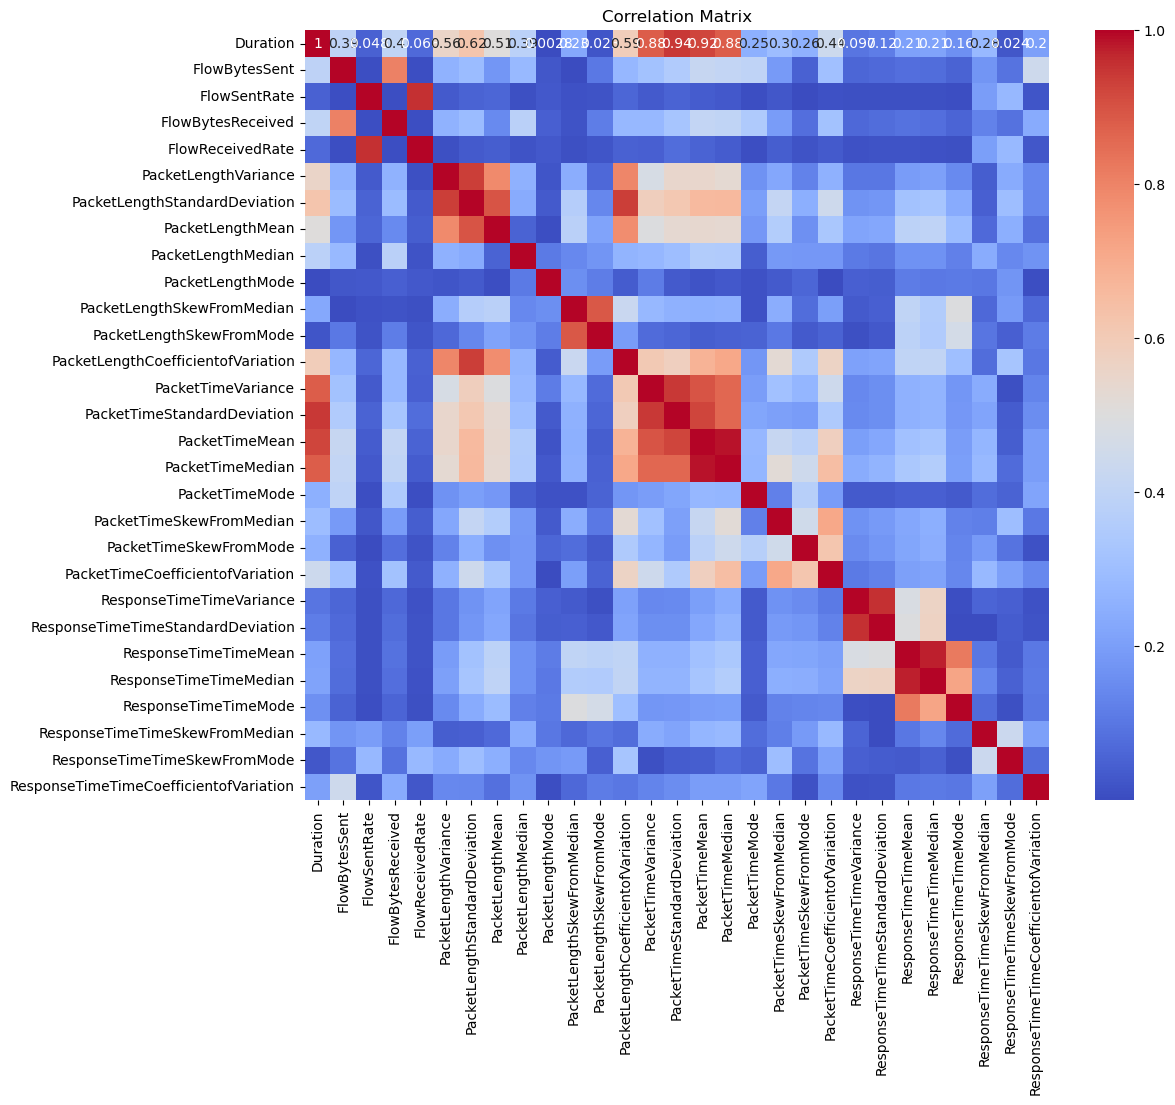

Highly correlated features (threshold > 0.9):
FlowReceivedRate: ['FlowSentRate']
PacketLengthStandardDeviation: ['PacketLengthVariance']
PacketLengthCoefficientofVariation: ['PacketLengthStandardDeviation']
PacketTimeStandardDeviation: ['Duration', 'PacketTimeVariance']
PacketTimeMean: ['Duration', 'PacketTimeStandardDeviation']
PacketTimeMedian: ['PacketTimeMean']
ResponseTimeTimeStandardDeviation: ['ResponseTimeTimeVariance']
ResponseTimeTimeMedian: ['ResponseTimeTimeMean']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the datasets
benign = pd.read_csv('l2-benign.csv')
malicious = pd.read_csv('l2-malicious.csv')

# Combine the datasets
data = pd.concat([benign, malicious], ignore_index=True)

# Drop columns we want to ignore
data.drop(['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'TimeStamp'], axis=1, inplace=True)

# Encode labels
data['Label'] = data['Label'].map({'Benign': 0, 'Malicious': 1})

# Split data into features and target
X = data.drop('Label', axis=1)
y = data['Label']

# Calculate the correlation matrix
corr_matrix = X.corr().abs()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Identify highly correlated features (threshold = 0.9)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Print highly correlated features
print("Highly correlated features (threshold > 0.9):")
for column in to_drop:
    correlated_features = upper.index[upper[column] > 0.9].tolist()
    print(f"{column}: {correlated_features}")

# Drop highly correlated features
X.drop(columns=to_drop, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the genetic algorithm for feature selection
def genetic_algorithm_feature_selection(X_train, y_train, n_gen=10, pop_size=20):
    n_features = X_train.shape[1]
    
    # Define individual and fitness functions
    creator.create('FitnessMax', base.Fitness, weights=(1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)
    
    toolbox = base.Toolbox()
    toolbox.register('attr_bool', np.random.randint, 0, 2)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    
    def eval_one_max(individual):
        mask = np.array(individual, dtype=bool)
        if np.sum(mask) == 0:
            return 0,
        clf = XGBClassifier(eval_metric='logloss')
        clf.fit(X_train[:, mask], y_train)
        return clf.score(X_train[:, mask], y_train),
    
    toolbox.register('mate', tools.cxTwoPoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
    toolbox.register('select', tools.selTournament, tournsize=3)
    toolbox.register('evaluate', eval_one_max)
    
    # Run the genetic algorithm
    pop = toolbox.population(n=pop_size)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_gen, verbose=False)
    
    # Select the best individual
    best_ind = tools.selBest(pop, 1)[0]
    return np.array(best_ind, dtype=bool)

# Run the genetic algorithm to select features
selected_features = genetic_algorithm_feature_selection(X_train.values, y_train.values)

# Train the XGBoost classifier on the selected features
clf = XGBClassifier(eval_metric='logloss')
clf.fit(X_train.values[:, selected_features], y_train)

# Predict on the test set
y_pred = clf.predict(X_test.values[:, selected_features])

# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate the number of false negatives and false positives
fn = cm[1, 0]
fp = cm[0, 1]
print(f"Number of False Negatives: {fn}")
print(f"Number of False Positives: {fp}")

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

# Number of features selected
num_features_selected = np.sum(selected_features)
print(f"Number of Features Selected: {num_features_selected}")

# Plot the feature selection graph
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), selected_features)
plt.xlabel('Feature Index')
plt.ylabel('Selected (1) / Not Selected (0)')
plt.title('Feature Selection using Genetic Algorithm')
plt.show()
